<img src="https://www.th-ab.de/typo3conf/ext/th_ab/Resources/Public/assets/logo-th-ab.svg" alt="TH-AB Logo" width="200"/>

Prof. Dr. Möckel, Prof. Dr. Radke, Katharina Kuhnert

Maschinelles Lernen Schwerpunkt Data Science<br>
SoSe 2024

**Excercise: Recurrent Neural Networks for Trajectory Forecasting**

Trajectory forecasting is a sequential prediction task, where a forecasting model predicts future trajectories of moving agents (humans) in a scene, based on their past trajectories.

In this exercise, you will learn how to build a system for predicting future trajectories of pedestrians using recurrent neural networks.

*Data Preperation*:
Download the [VRU Trajectory Dataset](https://www.th-ab.de/hochschule/organisation/organisationseinheiten/labor-fuer-kooperative-automatisierte-verkehrssysteme/trajectory-dataset) provided by the "Labor für kooperative automatisierte Verkehrssysteme".
The VRU Trajectory Dataset consists of 1068 pedestrian and 464 cyclist trajectories recorded at an urban intersection using cameras and LiDARs.

@MISC{VRUDataset,
  author = {},
  title = {{VRU} {T}rajectory {D}ataset},
  note = {\url{https://www.th-ab.de/vru-trajectory-dataset}},
}

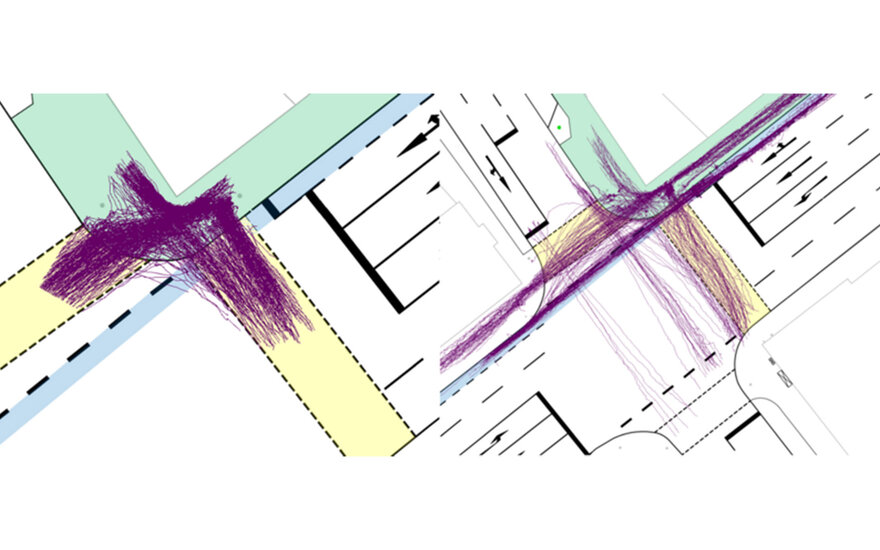



The complete dataset consists of 1532 files in csv format, where every file contains one VRU trajectory. A csv file consists of 4 columns:

    ID: Measurement IDs
    timestamp: Timestamp in seconds
    x: position in x-direction in meter
    y: position in y-direction in meter

Note: Due to privacy laws, we are not able to publish image data.


# Utils

## Imports

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import json

import os
import time
import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import copy

## Transformation to ego coordinates

In [2]:
# estimate a VRUs moving direction
def estimate_ego_transform(X):
    # get last point as reference position
    reference_position = X[:,-1:,:]
    X_translated = X - reference_position
    X_normed = X_translated / np.linalg.norm(X_translated)
    direction = np.sum(X_normed, axis=1)
    # determine angle between the orientation and the y-axis
    rotation_angle = np.arctan2(direction[:,0], -direction[:,1])
    return rotation_angle, reference_position

# build rotation matrix
def build_R(rotation_angle):
        # get identity matrices
        R = np.zeros((*rotation_angle.shape, 2, 2))
        R[..., 0, 0] = np.cos(rotation_angle)
        R[..., 0, 1] = np.sin(rotation_angle)
        R[..., 1, 0] = -np.sin(rotation_angle)
        R[..., 1, 1] = np.cos(rotation_angle)
        return R

# build inverse of rotation matrix
def build_R_inv(rotation_angle):
    # get identity
    rotation_angle = -rotation_angle
    R_inv = np.zeros((*rotation_angle.shape, 2, 2))
    R_inv[..., 0, 0] = np.cos(rotation_angle)
    R_inv[..., 0, 1] = np.sin(rotation_angle)
    R_inv[..., 1, 0] = -np.sin(rotation_angle)
    R_inv[..., 1, 1] = np.cos(rotation_angle)
    return R_inv

# transform from world coordinates to ego coordinates
def world2ego(X,rotation_angle,translation):
    R = build_R(rotation_angle)
    X_t = X - translation
    X_Rt = bat_mat_vec_mult(X_t,R)
    return X_Rt

# transform from ego coordinates to world coordinates
def ego2world(X,rotation_angle,translation):
    R_inv =build_R_inv(rotation_angle)
    X_R = bat_mat_vec_mult(X,R_inv)
    X_tR = X_R + translation
    return X_tR

# simple helper for batched matrix multiplication (with einsum)
def bat_mat_vec_mult(a, M):
    # does Ma
    return np.einsum('...ij,...j->...i', M[...,np.newaxis,:,:], a, optimize=True)

# high level method to partition a large trajectory with a sliding window
def crop_trajectory(a, n_in, n_out=None, dims=2):
    '''
    Crops a Sequence into Samples by appling a rolling window
    @param a:     the trajectory
    @param n_in:  size of the input window
    @param n_out: size of the ground truth window
    @param dims:  the dimensions of the trajectory to be used
    @return:  the cropped input trajectory and if n_out is not none the cropped
    @raises:  Value errors
    '''
    if dims > a.shape[-1]:
        raise ValueError('The trajectory only has %d dimensions' % a.shape[-1])
    if not isinstance(n_out, type(None)):
        X = rolling_window(a[..., :-n_out, :], shape=(n_in, dims))
        y = rolling_window(a[..., n_in:, :], shape=(n_out, dims))
        return X, y
    else:
        X = rolling_window(a[..., :, :], shape=(n_in, dims))
        return X

# a sliding window method
def rolling_window(a, shape):
    '''
    sliding window over a trajectory

    @param a: (ndarray)   input trajectory (e.g. 2d trajectory got the shape (n_samples,2))
    @param shape: (tuple) shape for the sliding window (e.g. for 50 samples of a 2d trajectory use (50,2))
    @return: (ndarray)    rolling window (e.g. for 50 samples of a 2d trajectory, the result has the shape (n_samples,50,2))

    '''
    s = (a.shape[-2] - shape[-2] + 1,) + (a.shape[-1] - shape[-1] + 1,) + shape
    strides = a.strides + a.strides
    astrided_array = np.lib.stride_tricks.as_strided(a, shape=s, strides=strides).squeeze()
    return astrided_array


## Plotting

In [3]:
# a method to plot multiple trajectories in world coordinates
def plot_trajectories(trajectory_data, keys):
    """
    Plot x and y coordinates of the passed trajectories.
    Parameters
    ----------
        traj : numpy array
            trajectories for plotting.
    """
    for k in keys:
      t = trajectory_data[k]
      plt.plot(t[:,0], t[:,1], label=k)
    plt.gca().set_aspect('equal')
    plt.grid()
    plt.title('Aschaffenburg Trajectory Dataset')
    plt.xlabel("x / m")
    plt.ylabel("y / m")
    #plt.legend()
    plt.show()
    plt.close()

# plot a single trajectory in ego coordinates
def plot_ego(X,y):
    """
    Plot x and y coordinates of the passed trajectories.
    Parameters
    ----------
        traj : numpy array
            trajectories for plotting.
    """

    plt.plot(X[:,0], X[:,1],color='r',label="X")
    plt.plot(y[:,0], y[:,1],color='b',label="y")
    plt.gca().set_aspect('equal')
    plt.grid()
    plt.title('ego coordinates')
    plt.xlabel("x / m")
    plt.ylabel("y / m")
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# plot a single trajectory in ego coordinates
def plot_ego_forecast(X,y,f):
    """
    Plot x and y coordinates of the passed trajectories.
    Parameters
    ----------
        traj : numpy array
            trajectories for plotting.
    """

    plt.plot(X[:,0], X[:,1],color='r',label="X")
    plt.plot(y[:,0], y[:,1],color='b',label="y_gt")
    plt.plot(f[:,0], f[:,1],color='g',label="y_forecast")
    plt.gca().set_aspect('equal')
    plt.grid()
    plt.title('ego coordinates')
    plt.xlabel("x / m")
    plt.ylabel("y / m")
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.legend()
    plt.show()


# Data Preperation

Download the dataset

The Dataset is loaded automatic. For pedestrians the fps is 50 for cyclist the fps is 12.5. For now we use pedestrians.

In [4]:
!wget https://www.th-ab.de/fileadmin/th-ab-redaktion/dokumente/Labore/Kooperative_automatisierte_Verkehrssysteme/VRUT_Dataset_complete.tar.gz
!tar -xf VRUT_Dataset_complete.tar.gz

/usr/sbin/sh: line 1: wget: command not found
tar: VRUT_Dataset_complete.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


We find every csv in the extracted folder for pedestrians, since every trajectory is saved in a single csv

In [5]:
import glob
files = glob.glob(f"VRU_dataset/pedestrians/*/*.csv")

In [6]:
from sklearn.model_selection import train_test_split
# split dataset to 60% train, 20% test and 20% val
train_set_keys, val_set_keys = train_test_split(files, test_size=0.4, random_state=42)
test_set_keys, val_set_keys = train_test_split(val_set_keys, test_size=0.5, random_state=42)

ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# from google.colab import files
import pandas as pd
import io
# build a empty dict to save trajectory data scenes
trajectory_data = {}

#load train data
for key in train_set_keys:
  trajectory_data[key] = pd.read_csv(key, encoding = 'utf8').to_numpy()[...,2:4]
#load test data
for key in test_set_keys:
  trajectory_data[key] = pd.read_csv(key, encoding = 'utf8').to_numpy()[...,2:4]
#load val data
for key in val_set_keys:
  trajectory_data[key] = pd.read_csv(key, encoding = 'utf8').to_numpy()[...,2:4]

Plot the loaded data in world coordinates

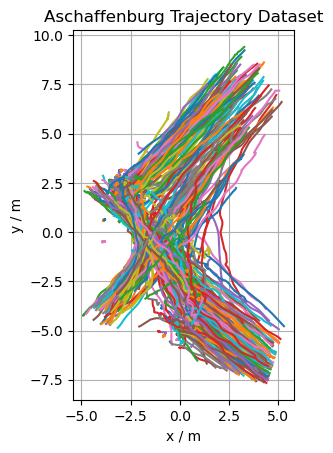

In [ ]:
plot_trajectories(trajectory_data, train_set_keys)

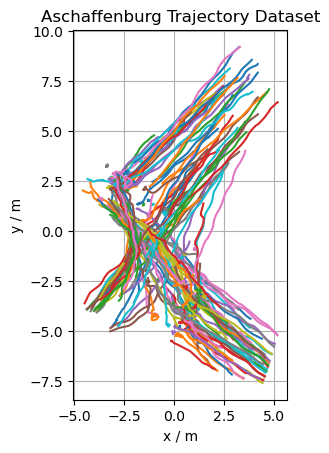

In [ ]:
plot_trajectories(trajectory_data, test_set_keys)

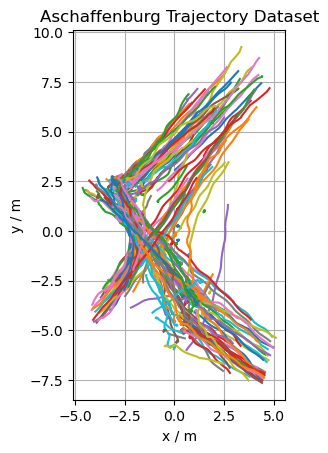

In [ ]:
plot_trajectories(trajectory_data, val_set_keys)

After loading the trajectories we can see, that they are distributed in a world coordinate system. This world coordinate system is very dependent on the recording system. If you build a prediction system in these world coordinates, you may bias the prediction system on the environment in which it was created.
This is not desirable for scalability and transferability of the prediction system. Furthermore, trajectories can have different length.

To avoid this and to cut the trajectories into processable chunks, we use an ego coordinate system. In an ego coordinate system, the current position of a VRU is the zero point and the direction of motion corresponds to the y-axis. In the following, we transform the trajectories accordingly

Partition trajectories and transform to ego coordinates

In [ ]:
# parameters for building tajectory partitions in ego coordinates
fps = 50 # change to 12.5 for cyclists
input_horizon_in_s = 1.0
forecast_horizon_in_s = 2.5
input_horizon = int(input_horizon_in_s*fps)
forecast_horizon = int(fps*forecast_horizon_in_s)-1

# create a dict to save the ego coordinates
ego_traj = {}

In [ ]:
# loop over train data
for traj_key in tqdm(train_set_keys):
    full_traj = trajectory_data[traj_key]
    traj = np.array(full_traj).astype(np.float32)

    try:
        X, y = crop_trajectory(traj, n_in=input_horizon,n_out=forecast_horizon)
        rotation_angle, reference_position = estimate_ego_transform(X)
        X_ego = world2ego(X, rotation_angle, reference_position)
        y_ego = world2ego(y, rotation_angle, reference_position)
    except:
        continue
    # store the trajectory in a useable format
    ego_traj[traj_key] = {"X": X_ego, "y": y_ego,
                          "reference_position": reference_position,
                          "rotation_angle": rotation_angle}

100%|██████████| 640/640 [00:00<00:00, 1402.61it/s]


In [ ]:
# loop over test data
for traj_key in tqdm(test_set_keys):
    full_traj = trajectory_data[traj_key]
    traj = np.array(full_traj).astype(np.float32)

    try:
        X, y = crop_trajectory(traj, n_in=int(input_horizon_in_s*fps),n_out=int(fps*forecast_horizon_in_s)-1)
        rotation_angle, reference_position = estimate_ego_transform(X)
        X_ego = world2ego(X, rotation_angle, reference_position)
        y_ego = world2ego(y, rotation_angle, reference_position)
    except:
        continue
    # store the trajectory in a useable format
    ego_traj[traj_key] = {"X": X_ego, "y": y_ego,
                          "reference_position": reference_position,
                          "rotation_angle": rotation_angle}


100%|██████████| 214/214 [00:00<00:00, 1279.12it/s]


In [ ]:
# loop over validation data
for traj_key in tqdm(val_set_keys):
    full_traj = trajectory_data[traj_key]
    traj = np.array(full_traj).astype(np.float32)

    try:
        X, y = crop_trajectory(traj, n_in=int(input_horizon_in_s*fps),n_out=int(fps*forecast_horizon_in_s)-1)
        rotation_angle, reference_position = estimate_ego_transform(X)
        X_ego = world2ego(X, rotation_angle, reference_position)
        y_ego = world2ego(y, rotation_angle, reference_position)
    except:
        continue
    # store the trajectory in a useable format
    ego_traj[traj_key] = {"X": X_ego, "y": y_ego,
                          "reference_position": reference_position,
                          "rotation_angle": rotation_angle}

100%|██████████| 214/214 [00:00<00:00, 1307.94it/s]


In [ ]:
# stack to one big trajectory array

X_train = np.concatenate([ego_traj[traj_key]["X"] for traj_key in train_set_keys],axis=0)
y_train = np.concatenate([ego_traj[traj_key]["y"] for traj_key in train_set_keys],axis=0)

X_val = np.concatenate([ego_traj[traj_key]["X"] for traj_key in val_set_keys],axis=0)
y_val = np.concatenate([ego_traj[traj_key]["y"] for traj_key in val_set_keys],axis=0)

X_test = np.concatenate([ego_traj[traj_key]["X"] for traj_key in test_set_keys],axis=0)
y_test = np.concatenate([ego_traj[traj_key]["y"] for traj_key in test_set_keys],axis=0)

Build a torch dataset to load the trajectories

In [ ]:
class TrajectoryDataset(Dataset):
    def __init__(self, X, y):
        self.inputs = X # shape: (num_samples, input_seq_len, num_features)
        self.outputs = y  # shape: (num_samples, output_seq_len, num_features)
        assert self.inputs.shape[0] == self.outputs.shape[0], "Input and output data sizes do not match."

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        output_seq = self.outputs[idx]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(output_seq, dtype=torch.float32)

def get_dataloader(X, y, batch_size, shuffle=True):
    dataset = TrajectoryDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [ ]:
train_loader = get_dataloader(X_train,y_train,batch_size=64)
val_loader = get_dataloader(X_val,y_val,batch_size=64, shuffle=False)
test_loader = get_dataloader(X_test,y_test,batch_size=1, shuffle=False)

At this point its a good practice to test the data loader.

(1, 50, 2)


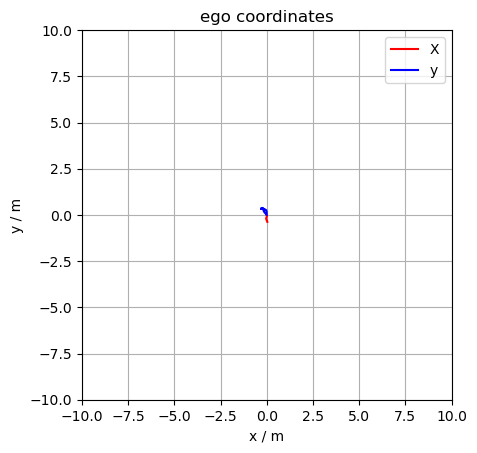

<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython import display
from time import sleep

i = 0
for inputs, targets in test_loader:
    print(inputs.numpy().shape)
    plot_ego(inputs.numpy()[0,...],targets.numpy()[0,...])
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.01)
    plt.close()
    i+=1
    if i > 10:
      break

# RNN Based Trajectory Forecast

## Forecasting Module

Each RNN unit (blue rectangles) takes one h_n (hidden state) and one input. Hidden dimension determines the feature vector size of the h_n (hidden state). At each timestep (t, horizontal propagation in the image) your rnn will take a h_n and input. Then if you have n_layers >1 it will create a intermediate output and give it to the upper layer(vertical). So hidden dimension determine the size of horizontal h_n in the image, whereas num_layers determine the number of blue cells in vertical axis in the image.
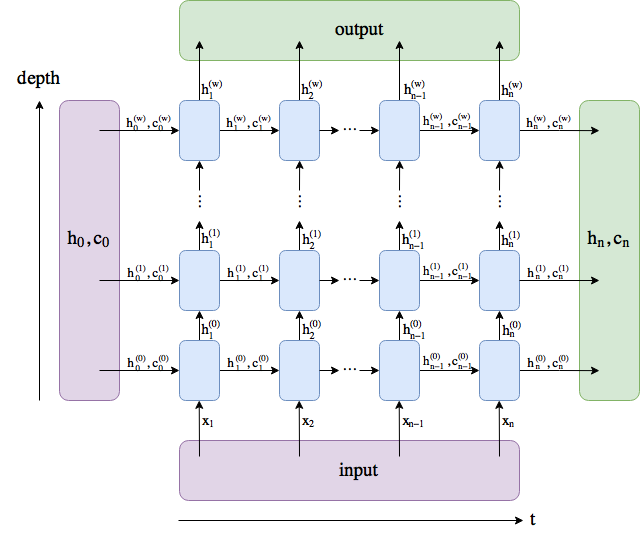

Build a LSTM for trajectory forcast as toch.nn module

In [ ]:
class LSTMTrajectoryForecast(nn.Module):
    def __init__(self, input_size, hidden_size,
                 n_forecast_horizons, output_size, num_layers):
        '''
        The forward method takes in an input tensor x of shape [batch_size, sequence_length, input_size].
        We pass this input through the LSTM layer using self.lstm(x),
        which returns an output tensor of shape [batch_size, sequence_length, hidden_size].
        We then select the last output of the LSTM sequence (lstm_out[:, -1, :])
        and pass it through the output layer
        (self.fc) to get the final output tensor of shape [batch_size, output_size].
        '''
        super(LSTMTrajectoryForecast, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_forecast_horizons = n_forecast_horizons

        self.num_layers = num_layers

        # Stacked LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size*n_forecast_horizons)


    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_size]

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out shape: [batch_size, sequence_length, hidden_size]

        # Output layer
        output = self.fc(lstm_out[:, -1, :])  # output shape: [batch_size, output_size*n_forecast_horizons]

        # reshape output: [batch_size, n_forecast_horizons, output_size]
        output = torch.reshape(output, (-1,self.n_forecast_horizons, self.output_size))

        return output


## Training

build a loss function

In [ ]:
def loss(output, target):
    # output shape: [batch_size, n_horizons, 2] (mu_x, mu_y)
    # target shape: [batch_size, n_horizons, 2] (x, y)

    batch_size = target.size(0)
    n_forecast_horizons = target.size(1)

    # get forecasts
    mu_x = output[..., 0]
    mu_y = output[..., 1]

    # get targets
    x = target[..., 0]
    y = target[..., 1]

    # build squared error (euclidean error)
    # error is in m for ego trajectories in m
    ee = (x-mu_x) ** 2 + (y-mu_y) ** 2

    # build mean squared error by averaging over forcasting horizonts and batch size
    mse = ee.mean()

    return mse

Build a trainer class

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer, device='cpu'):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, val_loader=None, num_epochs=10, checkpoint_path=None):
        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            train_loss_lst = []
            for inputs, targets in tqdm(train_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_loss_lst.append(loss.item())
            train_loss /= len(train_loader)

            # Validation
            if val_loader is not None:
                self.model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs = inputs.to(self.device)
                        targets = targets.to(self.device)
                        outputs = self.model(inputs)
                        loss = self.loss_fn(outputs, targets)
                        val_loss += loss.item()
                val_loss /= len(val_loader)
                print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs} | Train loss: {train_loss:.4f}")

            # Save checkpoint
            if checkpoint_path is not None:
                checkpoint = {
                    'epoch': epoch+1,
                    'model': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict()
                }
                torch.save(checkpoint, checkpoint_path)


Set up a train pipeline

In [ ]:
model = LSTMTrajectoryForecast(input_size=2, hidden_size=5,
                 n_forecast_horizons=124, output_size=2, num_layers=2)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = lambda output, target: loss(output, target)

# build trainer
trainer = Trainer(model, loss_fn, optimizer, device)
trainer.train(train_loader=train_loader, val_loader=val_loader, num_epochs=10)

100%|██████████| 1628/1628 [00:07<00:00, 211.40it/s]


Epoch 1/10 | Train loss: 0.4842 | Val loss: 0.3279


100%|██████████| 1628/1628 [00:07<00:00, 220.45it/s]


Epoch 2/10 | Train loss: 0.3187 | Val loss: 0.3195


100%|██████████| 1628/1628 [00:07<00:00, 220.69it/s]


Epoch 3/10 | Train loss: 0.3139 | Val loss: 0.3286


100%|██████████| 1628/1628 [00:07<00:00, 220.86it/s]


Epoch 4/10 | Train loss: 0.3105 | Val loss: 0.3172


100%|██████████| 1628/1628 [00:07<00:00, 215.75it/s]


Epoch 5/10 | Train loss: 0.3076 | Val loss: 0.3122


100%|██████████| 1628/1628 [00:07<00:00, 217.09it/s]


Epoch 6/10 | Train loss: 0.3056 | Val loss: 0.3083


100%|██████████| 1628/1628 [00:07<00:00, 217.66it/s]


Epoch 7/10 | Train loss: 0.3035 | Val loss: 0.3041


100%|██████████| 1628/1628 [00:07<00:00, 219.24it/s]


Epoch 8/10 | Train loss: 0.3019 | Val loss: 0.3070


100%|██████████| 1628/1628 [00:07<00:00, 216.27it/s]


Epoch 9/10 | Train loss: 0.3008 | Val loss: 0.3055


100%|██████████| 1628/1628 [00:07<00:00, 215.69it/s]


Epoch 10/10 | Train loss: 0.2995 | Val loss: 0.3025


## Test

In [ ]:
def test_loss(output, target):
    # output shape: [batch_size, n_horizons, 2] (mu_x, mu_y)
    # target shape: [batch_size, n_horizons, 2] (x, y)

    batch_size = target.size(0)
    n_forecast_horizons = target.size(1)

    # get forecasts
    mu_x = output[..., 0]
    mu_y = output[..., 1]

    # get targets
    x = target[..., 0]
    y = target[..., 1]

    # build squared error (euclidean error)
    # error is in m for ego trajectories in m
    ee = torch.sqrt((x-mu_x) ** 2 + (y-mu_y) ** 2)

    # build mean squared error by averaging over forcasting horizonts and batch size
    mse = ee.mean()



    return ee, mse

In [ ]:
class Tester:
    def __init__(self, model, loss_fn, device='cpu'):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.device = device

    def test(self, test_loader):
        se_lst = []
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                outputs = self.model(inputs)
                se, _ = self.loss_fn(outputs, targets)
                se_lst.append(se)
            se_c = torch.cat(se_lst,dim=0)
            # build mean over batch size
            aee = se_c.mean(dim=0)
            # build mean over forecast horizonts (equal weights)
            aaee = aee.mean(dim=0)
        return aaee.cpu().numpy(), aee.cpu().numpy()

In [ ]:
loss_fn_test = lambda output, target: test_loss(output, target)
tester = Tester(model, loss_fn_test, device)
ade, ada_per_time_horizont = tester.test(test_loader)

print("average displacement error in m: ", ade)

100%|██████████| 32643/32643 [00:22<00:00, 1470.17it/s]

average displacement error in m:  0.32183343


For a deeper insight we plot the displacement error over the forecasted time hoizonts

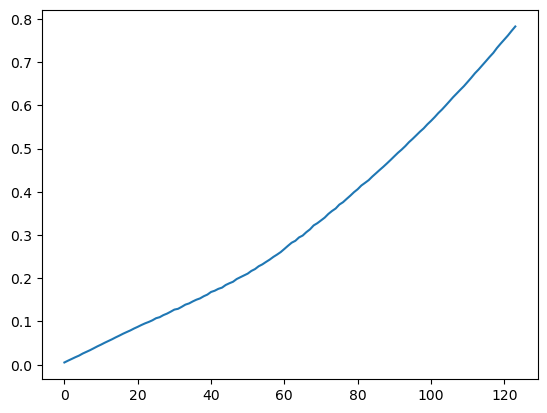

In [ ]:
plt.plot(ada_per_time_horizont)

## Inference

In [ ]:
class Predictor:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device

    def forecast(self, test_loader):
        se_lst = []
        i = 0
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader):
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                outputs = self.model(inputs)
                plot_ego_forecast(inputs.numpy()[0,...],targets.numpy()[0,...], outputs.numpy()[0,...])
                display.clear_output(wait=True)
                sleep(0.5)
                i+=1
                if i > 1000:
                  break
        plot_ego_forecast(inputs.numpy()[0,...],targets.numpy()[0,...], outputs.numpy()[0,...])
        display.clear_output(wait=True)



  3%|▎         | 1000/32643 [10:57<5:46:50,  1.52it/s]


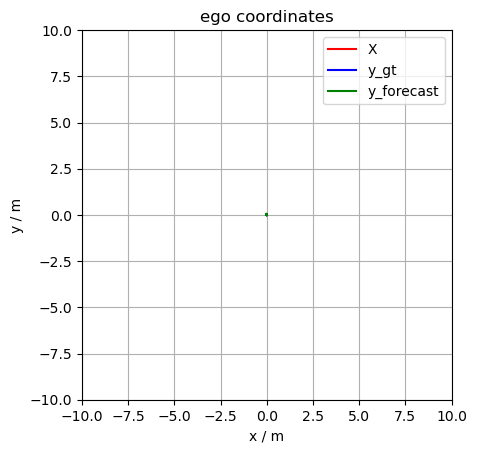

In [ ]:
from IPython import display
from time import sleep

trajectory_forecast = Predictor(model, device)
trajectory_forecast.forecast(test_loader)

# Challenges & Questions


Now that you have an understanding of RNNs and the task of trajectory prediction, it is up to you to use the given implementation to answer the following questions. Rerun the notebook with different parameters and document your results.

Q1: How does the displacement error behave over the forcast horizon?

Q2: The current implementation only offers data collected with a fixed frame rate. What would you do to make the implementation flexible?

Q3: Can you quantize the impacts of the models hidden size and number layers on the task of trajectory forecasting?

Q4: A observation time of 1 s (input horizont) is quite long in urban traffic. Can you quantize the impacts of the observation time? How would you change the RNN architecture to work with flexible input horizonts?